## Math Counts

## Scrape Competition Locations

In [15]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
import os
from geopy.geocoders import GoogleV3
import json
import time
import numpy as np

In [3]:
# Get all competitions from Math Counts website

columns = ["Competition Name", "URL", "State", "Date", "Type", "City"]
data = []

for page in range(0, 23):
    url = "https://www.mathcounts.org/dates-locations-coordinators?field_competition_state_value=All&page=" + str(page)
    html = requests.get(url).text
    soup = BeautifulSoup(html, "html.parser")
    
    table = soup.find("table", {"class": "views-table"}).find("tbody")
    for row in table.findAll("tr"):
        rowData = row.findAll("td")
        
        competitionName = rowData[0].getText().replace("\n", "")
        url = "https://www.mathcounts.org" + rowData[0].find("a")["href"]
        state = rowData[1].getText().strip()
        date = rowData[2].getText().strip()
        competitionType = rowData[3].getText().strip()
        city = rowData[4].getText().strip()
        
        data.append([competitionName, url, state, date, competitionType, city])

df = pd.DataFrame(data, columns=columns)

In [4]:
df.head()

,Competition Name,URL,State,Date,Type,City
0,Alaska State Competition,https://www.mathcounts.org/alaska-state-compet...,AK,,State,Canceled
1,Anchorage Chapter Competition,https://www.mathcounts.org/anchorage-chapter-c...,AK,02/08/2020,Chapter,Anchorage
2,Fairbanks Chapter Competition,https://www.mathcounts.org/fairbanks-chapter-c...,AK,02/15/2020,Chapter,Fairbanks
3,Remote Chapter Competition,https://www.mathcounts.org/remote-chapter-comp...,AK,02/08/2020,Chapter,Anchorage
4,Southeast AK Chapter Competition,https://www.mathcounts.org/southeast-ak-chapte...,AK,02/08/2020,Chapter,Juneau


In [5]:
# Filter only chapter locations 
df = df[df["Type"] != "State"]
df.head()

,Competition Name,URL,State,Date,Type,City
1,Anchorage Chapter Competition,https://www.mathcounts.org/anchorage-chapter-c...,AK,02/08/2020,Chapter,Anchorage
2,Fairbanks Chapter Competition,https://www.mathcounts.org/fairbanks-chapter-c...,AK,02/15/2020,Chapter,Fairbanks
3,Remote Chapter Competition,https://www.mathcounts.org/remote-chapter-comp...,AK,02/08/2020,Chapter,Anchorage
4,Southeast AK Chapter Competition,https://www.mathcounts.org/southeast-ak-chapte...,AK,02/08/2020,Chapter,Juneau
6,Birmingham Chapter Competition,https://www.mathcounts.org/birmingham-chapter-...,AL,02/29/2020,Chapter,Vestavia Hills


In [6]:
# Get facility locations for each competition 

columns = ["Competition Name", "URL", "State", "Date", "Type", "City", "Facility", "Street Address", "ZIP"]
data = []

for i, row in df.iterrows(): 
    html = requests.get(row["URL"]).text
    soup = BeautifulSoup(html, "html.parser")
    
    fields = soup.find("fieldset").findAll("div", {"class": "field"})
    
    facility = None 
    address = None 
    zipCode = None
    
    for field in fields:
        label = field.find("div", {"class": "field-label"}).text.replace(":", "").strip()
        item = field.find("div", {"class": "field-item"}).text.strip()
        
        if label == "Competition Facility": facility = item
        if label == "Facility Street Address": address = item
        if label == "Facility ZIP Code": zipCode = item
            
    data.append(list(row) + [facility, address, zipCode])

In [7]:
df = pd.DataFrame(data, columns=columns)
df.head()

,Competition Name,URL,State,Date,Type,City,Facility,Street Address,ZIP
0,Anchorage Chapter Competition,https://www.mathcounts.org/anchorage-chapter-c...,AK,02/08/2020,Chapter,Anchorage,University of Alaska Anchorage,None,None
1,Fairbanks Chapter Competition,https://www.mathcounts.org/fairbanks-chapter-c...,AK,02/15/2020,Chapter,Fairbanks,University of Alaska Fairbanks,None,None
2,Remote Chapter Competition,https://www.mathcounts.org/remote-chapter-comp...,AK,02/08/2020,Chapter,Anchorage,UAA,3211 Providence Drive,99503
3,Southeast AK Chapter Competition,https://www.mathcounts.org/southeast-ak-chapte...,AK,02/08/2020,Chapter,Juneau,University of Alaska Juneau,None,None
4,Birmingham Chapter Competition,https://www.mathcounts.org/birmingham-chapter-...,AL,02/29/2020,Chapter,Vestavia Hills,Liberty Park Middle School,17035 Liberty Parkway,35242


In [8]:
# Filter all competitions that do not have locations 
df = df[(df["Facility"].notnull()) & (df["Facility"] != "TBD") & (df["Facility"] != "tbd")]
df.head()

,Competition Name,URL,State,Date,Type,City,Facility,Street Address,ZIP
0,Anchorage Chapter Competition,https://www.mathcounts.org/anchorage-chapter-c...,AK,02/08/2020,Chapter,Anchorage,University of Alaska Anchorage,None,None
1,Fairbanks Chapter Competition,https://www.mathcounts.org/fairbanks-chapter-c...,AK,02/15/2020,Chapter,Fairbanks,University of Alaska Fairbanks,None,None
2,Remote Chapter Competition,https://www.mathcounts.org/remote-chapter-comp...,AK,02/08/2020,Chapter,Anchorage,UAA,3211 Providence Drive,99503
3,Southeast AK Chapter Competition,https://www.mathcounts.org/southeast-ak-chapte...,AK,02/08/2020,Chapter,Juneau,University of Alaska Juneau,None,None
4,Birmingham Chapter Competition,https://www.mathcounts.org/birmingham-chapter-...,AL,02/29/2020,Chapter,Vestavia Hills,Liberty Park Middle School,17035 Liberty Parkway,35242


In [22]:
# Geocode locations as coordinates 
API_TOKEN = None
with open('credentials.json') as f:
    data = json.load(f)
    API_TOKEN = data["API_KEY"]
geolocator = GoogleV3(api_key=API_TOKEN, timeout = 10)

In [24]:
columns = ["Competition Name", "URL", "State", "Date", "Type", "City", "Facility", "Street Address", "ZIP", "Lat", "Lon"]
data = []

for i, row in df.iterrows():
    query = row["Facility"] + ("" if row["Street Address"] is None else " " + row["Street Address"])
    location = geolocator.geocode(query, components={"city": row["City"], "administrative_area": row["State"], "country": "US"})
        
    if location is None: data.append(list(row) + [None, None])
    else: data.append(list(row) + [location.latitude, location.longitude]) 
    time.sleep(.5) # Sleep to prevent API overload

In [30]:
df = pd.DataFrame(data,columns=columns)
df.head()

,Competition Name,URL,State,Date,Type,City,Facility,Street Address,ZIP,Lat,Lon
0,Anchorage Chapter Competition,https://www.mathcounts.org/anchorage-chapter-c...,AK,02/08/2020,Chapter,Anchorage,University of Alaska Anchorage,None,None,61.191042,-149.819560
1,Fairbanks Chapter Competition,https://www.mathcounts.org/fairbanks-chapter-c...,AK,02/15/2020,Chapter,Fairbanks,University of Alaska Fairbanks,None,None,64.854665,-147.815676
2,Remote Chapter Competition,https://www.mathcounts.org/remote-chapter-comp...,AK,02/08/2020,Chapter,Anchorage,UAA,3211 Providence Drive,99503,61.191042,-149.819560
3,Southeast AK Chapter Competition,https://www.mathcounts.org/southeast-ak-chapte...,AK,02/08/2020,Chapter,Juneau,University of Alaska Juneau,None,None,58.385521,-134.640746
4,Birmingham Chapter Competition,https://www.mathcounts.org/birmingham-chapter-...,AL,02/29/2020,Chapter,Vestavia Hills,Liberty Park Middle School,17035 Liberty Parkway,35242,33.478673,-86.673070


In [32]:
df.to_csv("competitions.csv")

In [31]:
# Manually clean these points 
df[df["Lat"].isnull()].shape

(19, 11)

## Rural vs Urban

In [2]:
rural_df = pd.read_csv("rural tracts.csv")
rural_df.head()

,FIPS,POPULATION,POP_SQMI,POP2010,POP10_SQMI,WHITE,BLACK,AMERI_ES,ASIAN,HAWN_PI,...,AVE_FAM_SZ,HSE_UNITS,VACANT,OWNER_OCC,RENTER_OCC,SQMI,Shape_Leng,Shape_Area,HubName,HubDist
0,53049950300,3741.0,25.5,3625.0,24.7,2834.0,5.0,184.0,117.0,3.0,...,2.85,2405.0,837.0,1132.0,436.0,146.77,2.403418,0.044671,423,91796.24879
1,53049950500,2416.0,90.8,2475.0,93.0,2287.0,8.0,21.0,21.0,0.0,...,2.67,1948.0,773.0,820.0,355.0,26.62,0.661640,0.008056,337,120905.17670
2,53049950400,4125.0,6.9,3921.0,6.5,3557.0,19.0,88.0,29.0,2.0,...,2.82,1962.0,344.0,1267.0,351.0,600.57,3.732645,0.182239,423,88422.27785
3,53049950700,3112.0,275.9,2995.0,265.5,2788.0,13.0,39.0,15.0,3.0,...,2.51,3019.0,1529.0,1177.0,313.0,11.28,0.298990,0.003421,423,114732.43770
4,53049950600,1280.0,1000.0,1263.0,986.7,1153.0,1.0,13.0,12.0,3.0,...,2.52,1289.0,630.0,332.0,327.0,1.28,0.092103,0.000387,337,123698.78250


In [3]:
urban_df = pd.read_csv("urban tracts.csv")
urban_df.head()

,FIPS,POPULATION,POP_SQMI,POP2010,POP10_SQMI,WHITE,BLACK,AMERI_ES,ASIAN,HAWN_PI,...,AVE_FAM_SZ,HSE_UNITS,VACANT,OWNER_OCC,RENTER_OCC,SQMI,Shape_Leng,Shape_Area,HubName,HubDist
0,24005408502,5857.0,961.7,5586.0,917.2,4987.0,152.0,5.0,328.0,1.0,...,2.88,2271.0,76.0,1698.0,497.0,6.09,0.215445,0.001652,169,17353.08884
1,24005408400,1313.0,339.3,773.0,199.7,669.0,43.0,0.0,55.0,0.0,...,2.44,524.0,101.0,285.0,138.0,3.87,0.150694,0.001050,169,14224.95981
2,24005408505,3850.0,2452.2,3853.0,2454.1,3093.0,194.0,2.0,448.0,0.0,...,3.06,1612.0,76.0,1116.0,420.0,1.57,0.109310,0.000427,169,14509.92413
3,24005408503,3927.0,4848.1,3377.0,4169.1,1916.0,518.0,11.0,632.0,0.0,...,3.09,1448.0,59.0,602.0,787.0,0.81,0.084296,0.000220,169,14838.53125
4,24005408507,5982.0,9063.6,5966.0,9039.4,2835.0,1460.0,37.0,1031.0,2.0,...,2.90,3093.0,286.0,144.0,2663.0,0.66,0.068453,0.000179,169,15677.70616


In [5]:
urban_df.shape

(68277, 49)

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

rural_median 72623.6045
urban_median 18621.1504


Text(0, 0.5, 'Frequency')

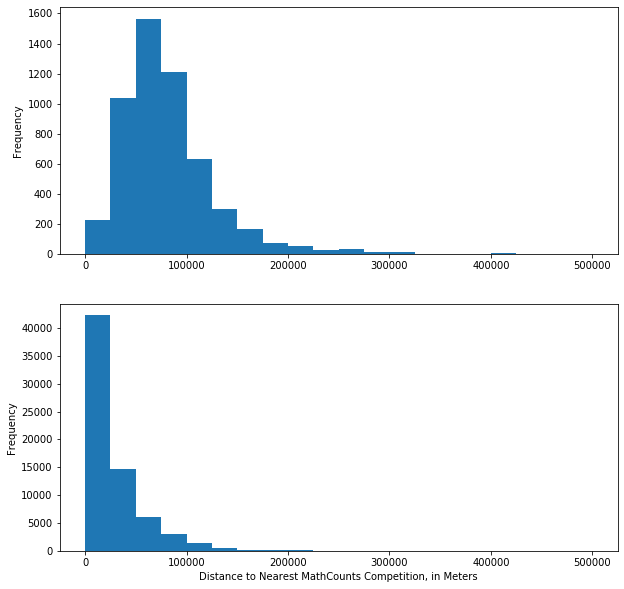

In [29]:
n_bins = 20

fig, axs = plt.subplots(2, 1, figsize=(10, 10))

rural_dists = rural_df["HubDist"]
urban_dists = urban_df["HubDist"]

print("rural_median", np.median(rural_dists))
print("urban_median", np.median(urban_dists))

# We can set the number of bins with the `bins` kwarg
(n0, bins0, patches0) = axs[0].hist(rural_dists, bins=n_bins, range = (0, 500000))
(n1, bins1, patches1) = axs[1].hist(urban_dists, bins=n_bins, range = (0, 500000))

axs[1].set_xlabel("Distance to Nearest MathCounts Competition, in Meters")
axs[0].set_ylabel("Frequency")
axs[1].set_ylabel("Frequency")

Rural tracts are unsurprisingly farther away from math competitions than urban tracts

In [33]:
data = zip(bins0, n0)
import csv
with open('rural_urban_histogram.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    writer.writerow(['bins','frequency_rural', 'frequency_urban'])
    
    for b, r, u in zip(bins0, n0, n1):
        writer.writerow([b, r, u])